In [2]:
import numpy as np
import torch

In [8]:
def num_inversions(rankings):
    
    inversions = []
    for row in rankings:
        ordered = sorted(range(len(row)), key=lambda k: row[k])
        inversions.append(sum(1 for i in range(len(ordered)) for j in range(i+1, len(ordered)) if ordered[i] > ordered[j]))
    print(inversions)
    return np.array(inversions)

# test code
n = 4 
r = 5 
ranking_matrix = np.zeros((n, r), dtype=int)


np.random.seed(0)  # For reproducibility
for i in range(n):
    ranking_matrix[i] = np.random.permutation(np.arange(1, r + 1))

print(ranking_matrix)
num_inversions(ranking_matrix)


[[3 1 2 4 5]
 [1 3 2 5 4]
 [2 4 5 1 3]
 [4 2 3 5 1]]
[2, 2, 5, 6]


array([2, 2, 5, 6])

In [95]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

def simulate_inversions(accuracies: np.ndarray, subgroup_sizes: np.ndarray, n_simulations: int, inversions_per_row):
    # NOTE THAT ACCURACIES SHOULD BE IN ASCENDING ORDER PER ROW
    # accuracies: n x r, where n is the number of subgroups, and r is the number of models
    # subgroup_sizes: n x 1, where n is the number of subgroups
    # inversions per row: n x 1, where n is the number of subgroups, and each entry is the number of inversions in that subgroup's ranking
    # n_simulations: number of simulations to run

    # inversions = num_inversions(rankings)
    # print(inversions.sum())

    # Sort accuracies in ascending order per row
    accuracies = np.sort(accuracies, axis=1)
    n, r = accuracies.shape
    total_inversion_counts = np.zeros(n_simulations)

    # Function to count inversions
    def count_inversions(list1, list2):
        inv_count = 0
        for i in range(len(list1)):
            for j in range(i + 1, len(list1)):
                if np.where(list2 == list1[i])[0] > np.where(list2 == list1[j])[0]:
                    inv_count += 1
        return inv_count

    # Conduct simulations
    np.random.seed(575)  # For reproducibility
    for sim in range(n_simulations):
        total_inversions = 0
        for i in range(n):
            Y = binom.rvs(subgroup_sizes[i], accuracies[i])  # Simulate Y values from Binomial distributions
            total_inversions += count_inversions(np.argsort(Y), np.argsort(accuracies[i]))
        total_inversion_counts[sim] = total_inversions

    # Now total_inversion_counts contains the total count of inversions across all rows in each simulation

    # To visualize the distribution of total inversions:
    plt.figure()
    plt.hist(total_inversion_counts, bins=np.arange(int(total_inversion_counts.min()), int(total_inversion_counts.max()) + 1) - 0.5, density=True, alpha=0.75)
    plt.xticks([int(tick) for tick in plt.xticks()[0] if tick >= 0])  # Ensure non-negative x-ticks
    plt.xlabel('Total Number of Inversions Across Rows (Subgroups)')
    plt.ylabel('Probability')
    plt.title('Distribution of Total Inversions Across Rows (Subgroups)')
    plt.show()

    # Compute the p-value
    observed_inversions = inversions_per_row.sum()
    p_value = (total_inversion_counts <= observed_inversions).mean()
    print(f'p-value: {p_value}')




/tmp/ipykernel_3030294/3393361876.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.where(list2 == list1[i])[0] > np.where(list2 == list1[j])[0]:


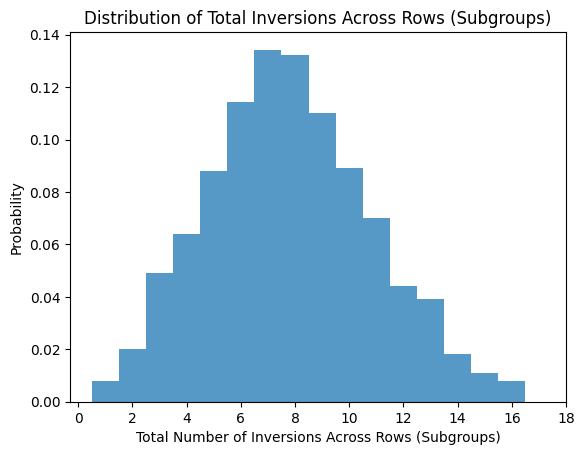

p-value: 0.477


7.0

In [113]:
P = np.array([[0.05, 0.051, 0.052, 0.053, 0.054], [0.05, 0.055, 0.0555, 0.0565, 0.0575]])
V = np.array([30, 40])

ranking_matrix = np.zeros((P.shape[0], P.shape[1]), dtype=int)

np.random.seed(575)  # For reproducibility
for i in range(P.shape[0]):
    ranking_matrix[i] = np.random.permutation(np.arange(1, P.shape[1] + 1))

correct_order = np.argsort(P, axis=1)
inversions_per_row = np.zeros(ranking_matrix.shape[0])

def count_inversions(list1, list2):
    inv_count = 0
    for i in range(len(list1)):
        for j in range(i + 1, len(list1)):
            if np.where(list2 == list1[i])[0] > np.where(list2 == list1[j])[0]:
                inv_count += 1
    return inv_count


for i in range(ranking_matrix.shape[0]):
    inversions_per_row[i] = count_inversions(ranking_matrix[i], correct_order[i])

simulate_inversions(P, V, 1000, inversions_per_row)

# correct_order
inversions_per_row.sum()


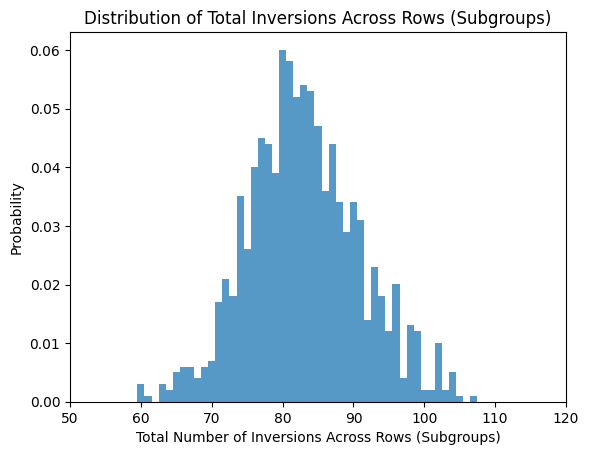

p-value: 0.2


In [114]:
# ranking_matrix
ds_preds = np.load('/data/ddmg/frank/shuvom/pred_matrices/ds_error_rates_all_classes.npy')
model_accuracy_ds = ds_preds[:, :, 1, 1]

model_rankings = model_accuracy_ds.argsort(axis=1)

model_rankings.shape

all_model_error_rates = np.load('/data/ddmg/frank/shuvom/pred_matrices/all_model_error_rates.npy')
all_model_error_rates_sorted_indices = all_model_error_rates.argsort(axis=1)
inversions_per_row = np.zeros(model_rankings.shape[0])

for i in range(model_rankings.shape[0]):
    inversions_per_row[i] = count_inversions(model_rankings[i], all_model_error_rates_sorted_indices[i])

simulate_inversions(all_model_error_rates, np.array([50 for i in range(100)]), 1000, inversions_per_row)

In [101]:
inversions_per_row.sum()

76.0

In [109]:
i=16
print(model_rankings[i])
print(all_model_error_rates_sorted_indices[i])
count_inversions(model_rankings[i], all_model_error_rates_sorted_indices[i])


[0 2 1]
[2 1 0]


2

In [76]:
all_model_error_rates[i]

array([0.78, 0.8 , 0.74])

In [86]:
# def count_inversions(list1, list2):
#     inv_count = 0
#     for i in range(len(list1)):
#         for j in range(i + 1, len(list1)):
#             if list2.index(list1[i]) > list2.index(list1[j]):
#                 inv_count += 1
#     return inv_count

count_inversions([1,2,0], [2,1,0])

1